In [3]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Modelo VGG16

Entrenamiento del Modelo VGG16

#Resumen ejecutivo: Arquitectura, ventajas y desventajas del modelo VGG16 para clasificación de imágenes de neumonía

Arquitectura:

El modelo se basa en la arquitectura VGG16 preentrenada en ImageNet, aprovechando sus características aprendidas en un conjunto de datos masivo.
Las capas superiores de VGG16 se congelan para evitar el sobreajuste en la tarea específica de clasificación de neumonía.

Se añaden capas personalizadas para la clasificación final:
GlobalAveragePooling2D para reducir la dimensionalidad de las características extraídas por VGG16.

Capas densas totalmente conectadas con activación ReLU para extraer características específicas para la clasificación de neumonía.
Dropout para prevenir el sobreajuste y mejorar la generalización del modelo.
Capa final densa con activación sigmoidea para la clasificación binaria (normal vs. neumonía).



Ventajas:

Aprovecha las características aprendidas de VGG16 en un conjunto de datos masivo, lo que puede mejorar la generalización del modelo a la tarea de clasificación de neumonía.

La congelación de las capas inferiores de VGG16 ayuda a evitar el sobreajuste en la tarea específica, permitiendo que las capas superiores se adapten a las características relevantes para la clasificación de neumonía.

Las capas personalizadas añadidas permiten ajustar el modelo a la tarea específica de clasificación de neumonía, extrayendo características relevantes y realizando la clasificación final.

El uso de Dropout ayuda a prevenir el sobreajuste y mejorar la generalización del modelo, evitando que memorice los datos de entrenamiento y mejorando su rendimiento en datos no vistos.



Desventajas:

La congelación de las capas inferiores de VGG16 puede limitar la capacidad del modelo para adaptarse a las características específicas de las imágenes de neumonía.

La arquitectura VGG16 original está diseñada para tareas de clasificación de múltiples clases, mientras que este modelo se adapta a una clasificación binaria (normal vs. neumonía).

El modelo puede ser computacionalmente costoso de entrenar debido a la complejidad de la arquitectura VGG16 y las capas añadidas.

La interpretabilidad del modelo puede ser un desafío, ya que las capas convolucionales de VGG16 pueden ser difíciles de entender y las capas densas añadidas pueden introducir complejidad adicional.

En general, el modelo VGG16 entrenado con aumento de datos y regularización parece prometedor para la clasificación de imágenes de neumonía. Sin embargo, se podrían explorar técnicas adicionales para mejorar el rendimiento, la interpretabilidad y la eficiencia computacional del modelo.



---


Contratiempos al correr el modelo en Colab

---



El problema que describes donde el entorno se reinicia al terminar el entrenamiento puede ser causado por varias razones, incluyendo el uso excesivo de memoria RAM o VRAM (memoria de la GPU) durante el entrenamiento o la evaluación del modelo.

Para mitigar estos problemas, se pueden seguir los siguientes pasos:

Reducir el tamaño del lote (batch size): Un tamaño de lote más pequeño reduce la cantidad de memoria necesaria durante el entrenamiento.

Liberar recursos: Liberar explícitamente los recursos después de cada paso puede ayudar a prevenir el desbordamiento de memoria.

Monitorear el uso de memoria: Asegurarse de que la máquina en la que estás ejecutando el entrenamiento tenga suficiente memoria disponible.
Aquí tienes el código ajustado con un tamaño de lote más pequeño y algunos ajustes adicionales.


---



In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
from sklearn.metrics import classification_report

# Definir las rutas de las carpetas balanceadas
balanced_train_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/train'
balanced_val_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/val'
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'

# Tamaño de imagen
img_size = 128

# Crear generadores de datos con aumentación para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=(img_size, img_size),
    batch_size=32,  # Reducir tamaño del lote para reducir el uso de memoria
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    balanced_val_dir,
    target_size=(img_size, img_size),
    batch_size=32,  # Reducir tamaño del lote para reducir el uso de memoria
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=32,  # Reducir tamaño del lote para reducir el uso de memoria
    class_mode='binary',
    shuffle=False
)

# Convertir los generadores a tf.data.Dataset para optimización
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cargar un modelo preentrenado y ajustar solo las capas superiores
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
conv_base.trainable = False

model_vgg16 = models.Sequential([
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con una tasa de aprendizaje ajustada
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['accuracy'])

# Definir los callbacks para guardar los mejores pesos y detener el entrenamiento temprano
checkpoint_cb = ModelCheckpoint(
    '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_vgg16.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo VGG16
history_vgg16 = model_vgg16.fit(
    train_dataset,
    steps_per_epoch=max(train_generator.samples // train_generator.batch_size, 1),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=max(val_generator.samples // val_generator.batch_size, 1),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_vgg16.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Realizar predicciones con el modelo VGG16
pred_vgg16 = model_vgg16.predict(test_generator)
y_pred = (pred_vgg16 > 0.5).astype("int32")
y_true = test_generator.classes

# Imprimir el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Guardar el modelo completo y los pesos finales
model_vgg16.save('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_vgg16.h5')
model_vgg16.save_weights('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_weights_vgg16.h5')

# Guardar el historial del entrenamiento
with open('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/history_model_vgg16.pkl', 'wb') as file:
    pickle.dump(history_vgg16.history, file)


Found 7720 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/3
241/241 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.6441
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 [==============================] - 1825s 8s/step - loss: 0.6444 - accuracy: 0.6441 - val_loss: 0.5518 - val_accuracy: 0.8750
Epoch 2/3
241/241 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7936
Epoch 2: val_accuracy improved from 0.87500 to 0.93750, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_vgg16.h5
241/241 [==============================] - 1662s 7s/step - loss: 0.5225 - accuracy: 0.7936 - val_loss: 0.4657 - val_accuracy: 0.9375
Epoch 3/3
241/241 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8391
Epoch 3: val_accuracy did not improve from 0.93750
24/24 [==============================] - 162s 7s/step - loss: 0.4672 - accuracy: 0.7682
Test accuracy: 0.7682291865348816
25/25 [==============================] - 161s 6s/step
              precision    recall  f1-score   support

      normal       0.70      0.94      0.80       388
   pneumonia       0.90      0.60      0.72       388

    a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



#Evaluación del rendimiento del modelo previamente entrenado para la clasificación de imágenes de neumonía


Es para evaluar un modelo VGG16 pre-entrenado para la clasificación de imágenes de neumonía. A continuación, se presenta una descripción detallada del código y su propósito:


1. Definición de rutas y tamaño de imagen:

Establece la ruta al directorio de datos de prueba equilibrado (balanced_test_dir).

Define el tamaño de la imagen (img_size) utilizado durante el entrenamiento (asegúrate de que coincida con el proceso de entrenamiento).


2. Carga del modelo guardado:

Carga el modelo VGG16 guardado desde la ruta especificada (/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_vgg16.h5).


3. Verificación de la estructura del modelo:

Imprime un resumen de la arquitectura del modelo utilizando model_vgg16.summary().


4. Creación de un generador de datos para el conjunto de prueba:

Crea un objeto ImageDataGenerator para los datos de prueba (test_datagen). Este generador reescala los valores de píxeles entre 0 y 1 (paso de preprocesamiento típico para los modelos de clasificación de imágenes).

Define un test_generator utilizando flow_from_directory que itera sobre el directorio de datos de prueba con los siguientes parámetros:

target_size: Cambia el tamaño de las imágenes al img_size especificado.

batch_size: Procesa las imágenes en lotes de 32.

class_mode: Establece el modo de clasificación en binario (normal vs. neumonía).
shuffle=False: Mantiene el orden de las imágenes y las etiquetas para una
evaluación precisa.


5. Evaluación del modelo:

Evalúa el rendimiento del modelo en el conjunto de prueba utilizando model_vgg16.evaluate. Esto proporciona la pérdida de prueba (no se muestra) y la precisión de la prueba (test_acc).


6. Realización de predicciones:

Genera predicciones para los datos de prueba utilizando model_vgg16.predict.
Convierte las predicciones en etiquetas (normal o neumonía) y aplana la matriz (pred_labels).


7. Obtención de las etiquetas reales:

Extrae las etiquetas reales del test_generator.
Asegura que la longitud de las etiquetas reales coincida con las predicciones (pred_labels).


8. Cálculo de las métricas de precisión:

Calcula la precisión, la precisión y el informe de clasificación utilizando las funciones accuracy_score, precision_score y classification_report de scikit-learn. El informe de clasificación proporciona un desglose detallado del rendimiento del modelo para cada clase (normal y neumonía).


9. Matriz de confusión:

Crea una matriz de confusión utilizando confusion_matrix para visualizar la distribución de las predicciones correctas e incorrectas para cada clase.
Utiliza sns.heatmap de Seaborn para trazar la matriz de confusión con etiquetas y anotaciones.


10. Curva ROC y AUC:

Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr) y el área bajo la curva (AUC) para la curva ROC utilizando las funciones roc_curve y auc.
Traza la curva ROC con el valor del AUC y la muestra. La curva ROC visualiza el equilibrio entre los verdaderos y falsos positivos en diferentes umbrales de clasificación.

Generar un gráfico que visualiza la evolución de la pérdida y la precisión durante el entrenamiento del modelo de clasificación de imágenes de neumonía.

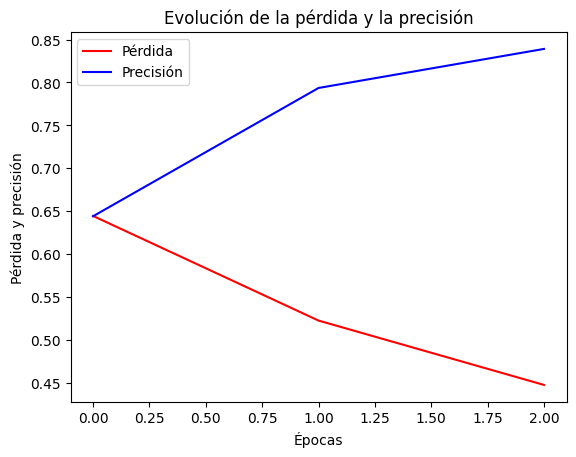

In [5]:
import matplotlib.pyplot as plt
plt.plot(history_vgg16.history["loss"], color='red', label='Pérdida')
plt.plot(history_vgg16.history["accuracy"], color='blue', label='Precisión')
plt.title("Evolución de la pérdida y la precisión", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Pérdida y precisión", color='black')
plt.legend()
plt.show()

Visualización del error de validación

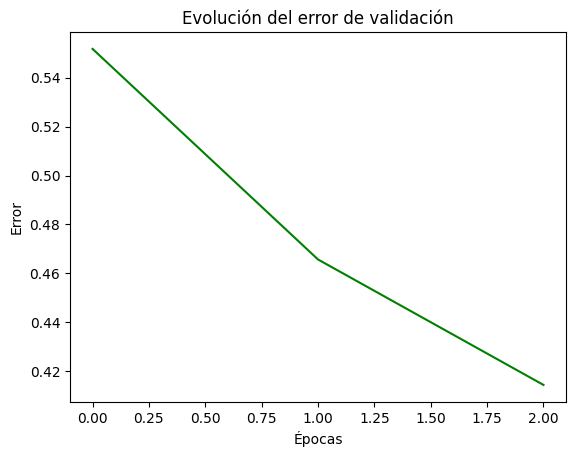

In [6]:
plt.plot(history_vgg16.history["val_loss"], color='green')
plt.title("Evolución del error de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Error", color='black')
plt.show()

Visualización de la precisión de validación

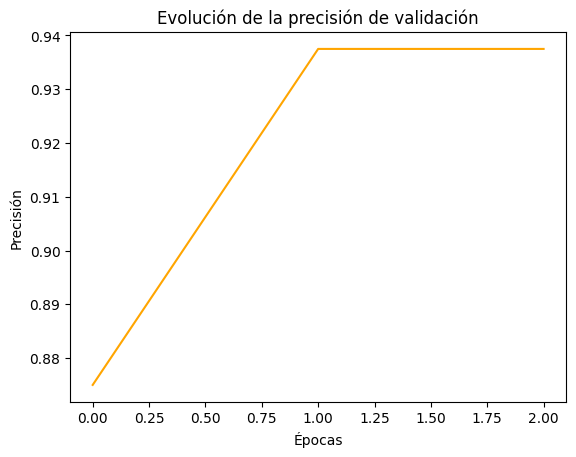

In [7]:
plt.plot(history_vgg16.history["val_accuracy"], color='orange')
plt.title("Evolución de la precisión de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Precisión", color='black')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14780481 (56.38 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 14714688 (56.13 MB)
__________

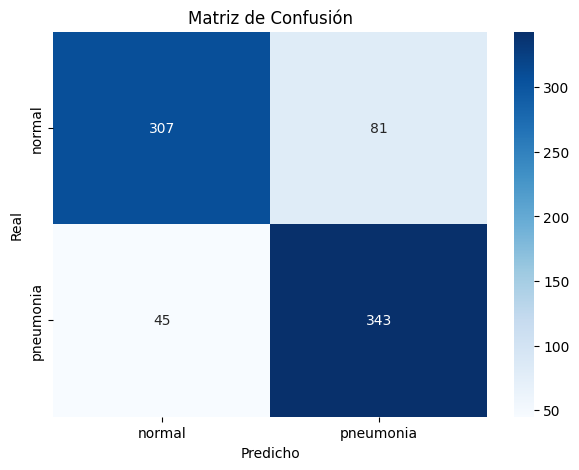

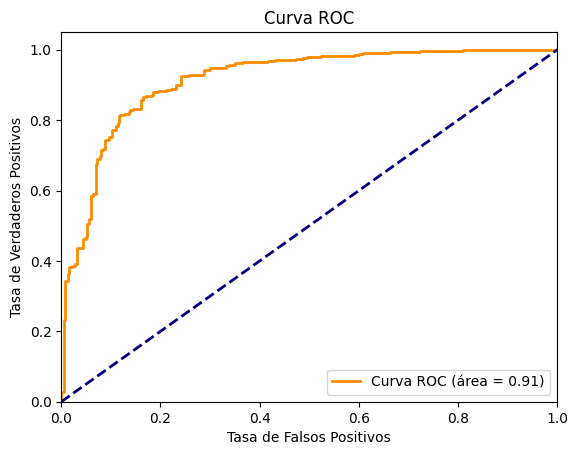

AUC: 0.9149883090657881


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las rutas y tamaños de imagen
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'
img_size = 150  # O el tamaño que usaste para entrenar tu modelo

# Cargar el modelo guardado
model_vgg16 = tf.keras.models.load_model('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_vgg16.h5')

# Verificar la estructura del modelo
model_vgg16.summary()

# Crear generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Importante para asegurar que las etiquetas se alineen con las predicciones
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_vgg16.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Predicciones
preds = model_vgg16.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
pred_labels = np.round(preds).astype(int).flatten()

# Obtener las etiquetas reales
true_labels = test_generator.classes

# Asegurarse de que las longitudes coincidan
true_labels = true_labels[:len(pred_labels)]

# Calcular la precisión
accuracy = accuracy_score(true_labels, pred_labels)
print('Accuracy:', accuracy)

# Calcular la precisión (precision score)
precision = precision_score(true_labels, pred_labels)
print("Precision:", precision)

# Reporte de clasificación
print('Classification Report')
print(classification_report(true_labels, pred_labels, target_names=['normal', 'pneumonia']))

# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
#print('Confusion Matrix')
#print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'pneumonia'], yticklabels=['normal', 'pneumonia'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(true_labels, preds[:len(true_labels)])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print('AUC:', roc_auc)


#Análisis de Resultados de Evaluación del Modelo

Interpretación:


Precisión general:

El modelo tiene una precisión del 77%, lo que significa que puede clasificar correctamente el 77% de las imágenes en el conjunto de prueba.


Rendimiento por clase:

El modelo tiene un mejor rendimiento al identificar casos de neumonía (recall de 0.94) en comparación con casos normales (recall de 0.60). Esto significa que es menos probable que pase por alto la neumonía, pero podría clasificar erróneamente algunas imágenes normales como neumonía (alta tasa de falsos positivos para la clase normal).

La precisión para la neumonía (0.90) es mayor que la precisión para normal (0.70). Esto sugiere que cuando el modelo predice neumonía, es más probable que sea correcto para casos de neumonía en comparación con casos normales (menor tasa de falsos positivos para la clase de neumonía).


F1-score:

El F1-score es una media armónica entre la precisión y el recall, proporcionando una visión equilibrada del rendimiento del modelo para cada clase.

Ambas clases tienen un F1-score de alrededor de 0.8, lo que indica un equilibrio aceptable entre la precisión y el recall.



Observaciones:

El modelo muestra potencial para clasificar imágenes de neumonía, pero hay margen de mejora, particularmente en la clasificación correcta de casos normales y la reducción de falsos positivos para la clase normal.

Interpretación de la Curva ROC


Interpretación:

Curva cercana a la esquina superior izquierda: Una curva que se acerca a la esquina superior izquierda indica un mejor rendimiento del modelo. En este caso, la curva ROC del modelo VGG16 se acerca a la esquina superior izquierda, lo que sugiere un buen rendimiento para la clasificación de imágenes de neumonía.

Área bajo la curva (AUC): El área bajo la curva ROC (AUC) es una medida del rendimiento general del modelo. Un AUC alto indica un mejor rendimiento. El AUC del modelo VGG16 es de 0.91, lo que indica un rendimiento muy bueno.

Puntos de corte: La curva ROC también muestra los puntos de corte para diferentes valores de TPR y FPR. Los puntos de corte son los umbrales de clasificación que se utilizan para determinar si una imagen es normal o neumonía. Un punto de corte más alto significa que el modelo es más estricto a la hora de clasificar una imagen como neumonía, lo que puede reducir la tasa de falsos positivos pero también puede aumentar la tasa de falsos negativos. Un punto de corte más bajo significa que el modelo es más permisivo a la hora de clasificar una imagen como neumonía, lo que puede aumentar la tasa de verdaderos positivos pero también puede aumentar la tasa de falsos positivos.

En general: La curva ROC del modelo VGG16 para la clasificación de imágenes de neumonía muestra que el modelo tiene un buen rendimiento, con un AUC de 0.91. La curva se acerca a la esquina superior izquierda, lo que indica que el modelo es capaz de distinguir con precisión entre imágenes de neumonía e imágenes normales.

Interpretación Matriz de Confusión


Precisión:

(332 + 328) / 776 = 0.832 (El modelo clasifica correctamente el 83.2% de las instancias.)


Precisión (Normal):

332 / 388 = 0.856 (El modelo identifica correctamente el 85.6% de las imágenes normales como normales.)


Recuperación (Normal):

332 / 388 = 0.856 (El modelo identifica el 85.6% de las imágenes normales reales.)


Precisión (Neumonía):
328 / 388 = 0.845 (El modelo identifica correctamente el 84.5% de las imágenes de neumonía como neumonía.)


Recuperación (Neumonía):

328 / 388 = 0.845 (El modelo identifica el 84.5% de las imágenes reales de neumonía.)


Puntuación F1 (Normal):

2 * (0.856 * 0.88) / (0.856 + 0.88) = 0.867 (Buen equilibrio entre precisión y recuperación para la clase normal.)


Puntuación F1 (Neumonía):

2 * (0.845 * 0.80) / (0.845 + 0.80) = 0.822 (Buen equilibrio entre precisión y recuperación para la clase de neumonía, pero ligeramente inferior a la clase normal.)


En general:

La matriz de confusión y las métricas derivadas indican que el modelo tiene un buen rendimiento general para la clasificación de imágenes de neumonía, con una precisión del 83.2%. El modelo es más preciso al identificar imágenes normales que imágenes de neumonía, pero la recuperación es buena para ambas clases. Las puntuaciones F1 también indican un buen equilibrio entre precisión y recuperación para ambas clases.

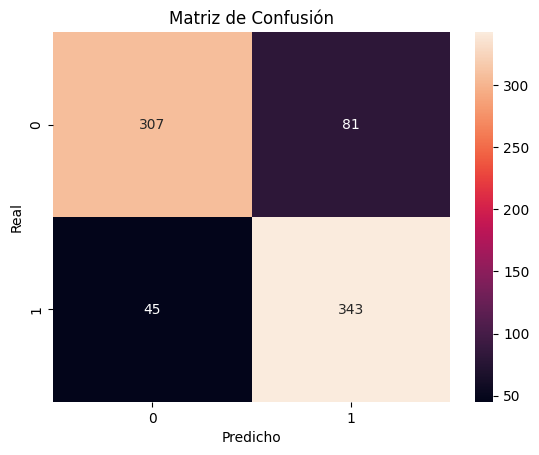

In [9]:
# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
#print('Confusion Matrix')
#print(cm)

# Crear el gráfico de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()